# Helmet Detection with YoLoV3 Algorithm

YOLOv3 (You Only Look Once, version 3) is a real-time object detection system that is fast and accurate, capable of detecting objects in images by predicting bounding boxes and class probabilities. We use YOLOv3 for helmet detection because it efficiently identifies and localizes helmets in images or video streams, ensuring safety compliance in environments such as construction sites or traffic monitoring.

### About Dataset:
- yolov3-helmet.weights - 234.9 MB

Contains the learned parameters that help YOLOv3 detect helmets.
- helmet.names - 7 Bytes

A file that specifies the class name "helmet" for the YOLOv3 model.
- yolov3-helmet.cfg – 8 KB

Configuration file that defines how YOLOv3 is structured and operates specifically for detecting helmet.

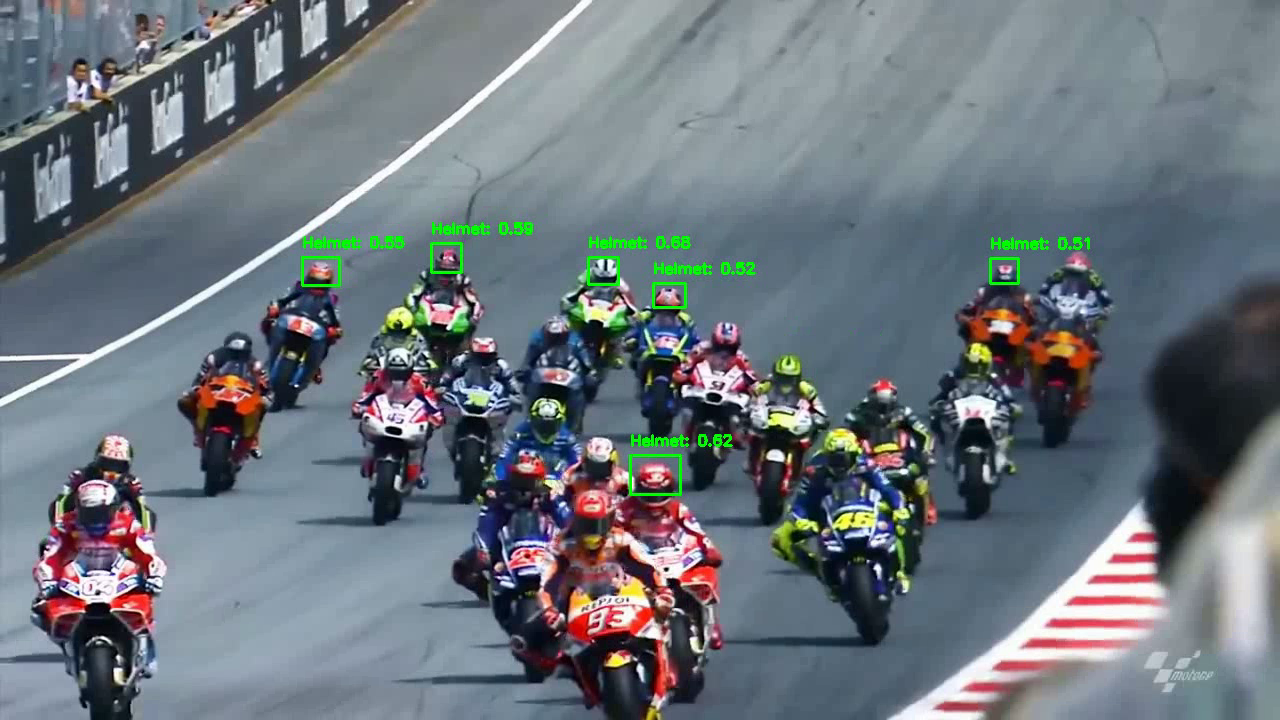

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Import Libraries

### DarkNet Repo

In [ ]:
# Clone darknet repository (adjust the URL if needed)
!git clone https://github.com/AlexeyAB/darknet


Cloning into 'darknet'...
remote: Enumerating objects: 15851, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15851 (delta 5), reused 12 (delta 4), pack-reused 15833
Receiving objects: 100% (15851/15851), 14.38 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (10675/10675), done.


In [ ]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!make


/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused variable ‘buff’ []8;;https://gcc.gnu.

In [28]:
# Import the OpenCV library for computer vision tasks
import cv2

# Import the NumPy library for numerical operations and array manipulations
import numpy as np

# Import the Matplotlib library for plotting and visualization
import matplotlib.pyplot as plt

# Import cv2_imshow function from google.colab.patches to display images in Google Colab
from google.colab.patches import cv2_imshow


# Load Data

In [13]:
# for helmet
weights1_path  = '/content/drive/MyDrive/AI Project/helmet detection/Dataset/yolov3-helmet.weights'
configuration1_path = '/content/drive/MyDrive/AI Project/helmet detection/Dataset/yolov3-helmet.cfg'

labels_file_path = '/content/drive/MyDrive/AI Project/helmet detection/Dataset/helmet.names'

In [14]:
# read Label from file:

with open(labels_file_path, 'r') as f:
    labels1 = f.read().strip().split('\n')

# Print labels
print(labels1)

['Helmet']


# Helmet Detection in an Image

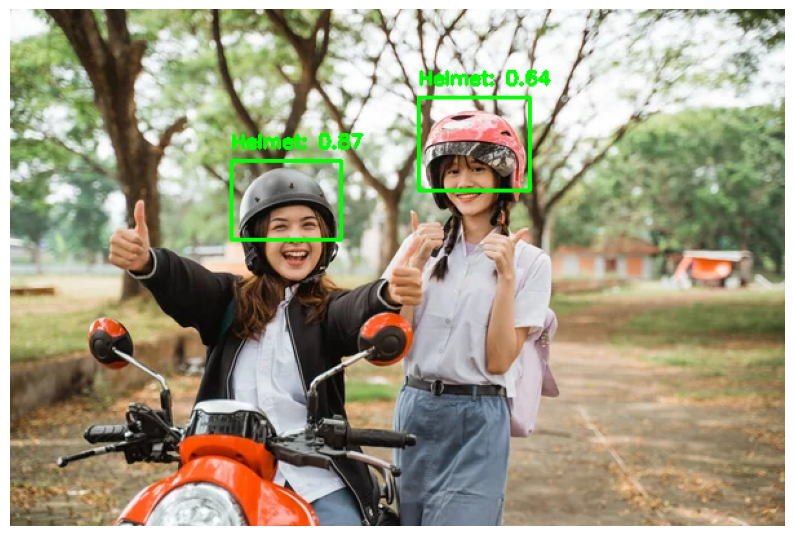

In [15]:

# Load YOLOv3 network from Darknet with specified configuration and weights
net = cv2.dnn.readNetFromDarknet(configuration1_path, weights1_path)

# Load class names
with open(labels_file_path, 'r') as f:
    classes = f.read().strip().split('\n')

# Function to perform helmet detection on a single image
def detect_helmet_in_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image '{image_path}' not found.")
        return

    # Perform object detection
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    layer_outputs = net.forward(net.getUnconnectedOutLayersNames())

    # Process detections
    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = int(np.argmax(scores))
            confidence = float(scores[class_id])
            if confidence > 0.5 and class_id == 0:  # Assuming class_id 0 is for "helmet"
                center_x = int(detection[0] * image.shape[1])
                center_y = int(detection[1] * image.shape[0])
                w = int(detection[2] * image.shape[1])
                h = int(detection[3] * image.shape[0])

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Apply non-maximum suppression
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

    # Draw bounding boxes and labels
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the resulting image with detections
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/AI Project/helmet detection/Dataset/test_helmet2.jpg'
detect_helmet_in_image(image_path)


# Helmet Detection in a Video

In [20]:
# Load YOLOv3 network from Darknet with specified configuration and weights

net = cv2.dnn.readNetFromDarknet(configuration1_path, weights1_path)

# Load class names
with open(labels_file_path, 'r') as f:
    classes = f.read().strip().split('\n')

# Function to perform helmet detection on a video
def detect_helmet_in_video(input_video_path, output_video_path):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform object detection
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        layer_outputs = net.forward(net.getUnconnectedOutLayersNames())

        # Process detections
        boxes = []
        confidences = []
        class_ids = []

        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5 and class_id == 0:  # Assuming class_id 0 is for "helmet"
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        # Apply non-max suppression
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=0.5, nms_threshold=0.4)

        # Draw bounding boxes and labels
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Write the frame into the output video
        out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Example usage
input_video_path = '/content/drive/MyDrive/AI Project/helmet detection/Dataset/MotoGP - video.mp4'
output_video_path = '/content/drive/MyDrive/AI Project/helmet detection/Dataset/helmet_output_video.avi'

detect_helmet_in_video(input_video_path, output_video_path)


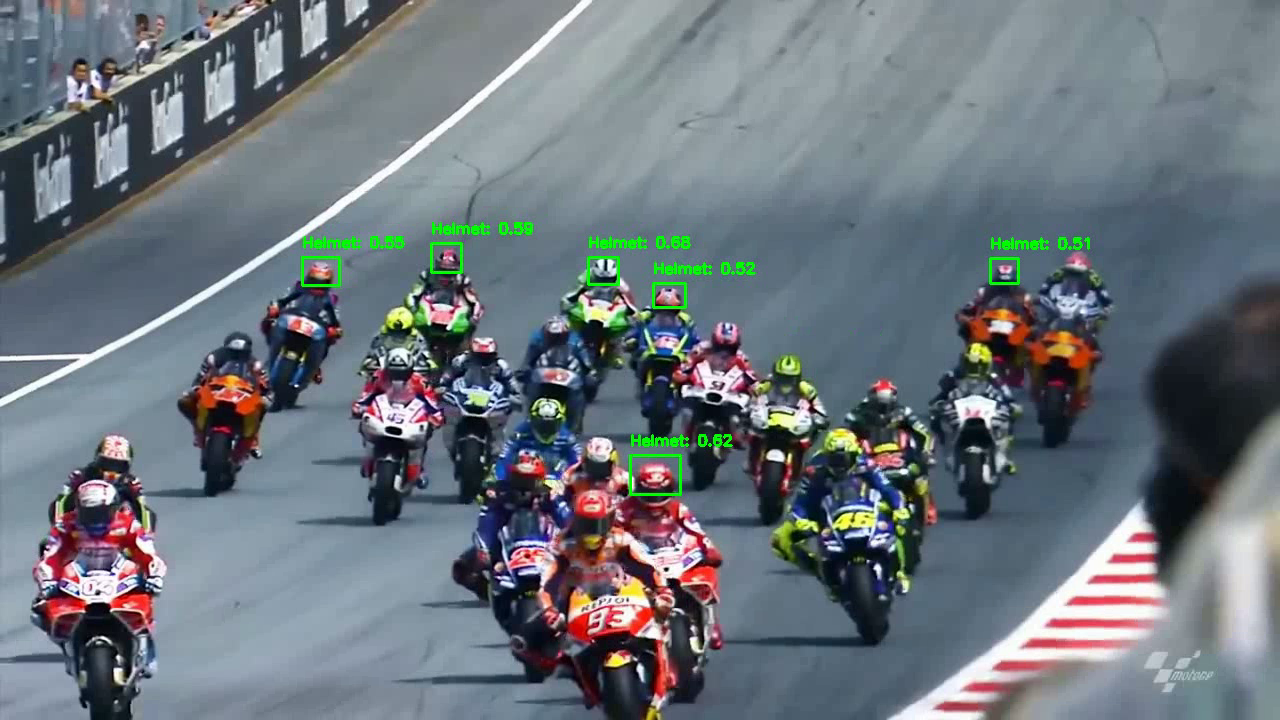

# To Play Generated Video after Helmet Detection

In [27]:


def play_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Display the frame
        cv2_imshow(frame)

        # Wait for a short period to simulate video playback speed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object
    cap.release()

# Example usage
#video_path = '/content/drive/MyDrive/AI Project/helmet detection/Dataset/helmet_output_video.avi'  # Replace with your .avi video file path
#play_video(video_path)
